In [1]:
import numpy as np
import numba
import params

In [2]:
species = [("preMiR", 1),
          ("preMiR_Dicer", 0),
          ("miRNA", 0),
          ("Dicer", 50)]

In [3]:
species

[('preMiR', 1), ('preMiR_Dicer', 0), ('miRNA', 0), ('Dicer', 50)]

In [4]:
init_dicer, init_premirna1, init_premirna2, init_premirna3, init_premirna4, \
init_premirna5, init_premirna1_dicer, init_premirna2_dicer, init_premirna3_dicer, \
init_premirna4_dicer, init_premirna5_dicer, init_mirna1, init_mirna2, init_mirna3, \
init_mirna4, init_mirna5 = params.init_values

In [5]:
ka1, ka_1, ka2, kb1, kb_1, kb2, kc1, kc_1, kc2, kd1, kd_1, kd2, ke1, ke_1, ke2 = params.theta

In [6]:
from scipy.integrate import solve_ivp

In [9]:
def make_inits(num_preMiR, pMiR, dicer_pMiR, miR, dicer):
    """
    Function to generate vector of initial concentrations for all species.
    
    Args:
    num_preMiR:    int, number of pre-miRNA species
    pMiR:          list of floats, initial concentration of pre-miRNA
    dicer_pMiR:    list of floats, initial concentration Dicer and pre-miRNA complexes
    miR:           list of floats, initial concentration of mature miRNA
    dicer:         float, initial concentration of dicer
    """
    
    assert num_preMiR == len(pMiR), "The number of concentrations given do \
    not correspond with the number of species"
    assert num_preMiR == len(dicer_pMiR), "The number of concentrations given do not \
    correspond with the number of species"
    
    init_concs = [pMiR[0], dicer_pMiR[0], miR[0]]
    init_species = {"pMiR0": pMiR[0], "dicer_pMiR0": dicer_pMiR[0], "miR": miR[0]}
    
    for i in range(1, num_preMiR):
        init_concs.append(pMiR[i])
        init_concs.append(dicer_pMiR[i])
        init_concs.append(miR[i])
        
        init_species["preMiR"+str(i)] = pMiR[i]
        init_species["dicer_preMiR"+str(i)] = dicer_pMiR[i]
        init_species["miR"+str(i)] = miR[i]
    
    init_concs.append(dicer)
    init_species["dicer"] = dicer
        
    return init_concs, init_species

In [10]:
inits = make_inits(5, [params.init_premirna1] * 5, [params.init_premirna1_dicer] * 5, \
                   [params.init_mirna1]*5, params.init_dicer)

In [11]:
inits

([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 50],
 {'pMiR0': 1,
  'dicer_pMiR0': 0,
  'miR': 0,
  'preMiR1': 1,
  'dicer_preMiR1': 0,
  'miR1': 0,
  'preMiR2': 1,
  'dicer_preMiR2': 0,
  'miR2': 0,
  'preMiR3': 1,
  'dicer_preMiR3': 0,
  'miR3': 0,
  'preMiR4': 1,
  'dicer_preMiR4': 0,
  'miR4': 0,
  'dicer': 50})

In [65]:
def makeModel(init_values, ka, kb, kc):
    """
    Function to generate string of functions for passing to ODE solver
    
    init_vals:      List of initial concentration of free pre-miRNA concentration for
                    each pre-mirna, pre-mirna x dicer concentration, mirna concentration
                    and dicer concentration. Alternating pre-mirna (a), pre-mirna dicer (b),
                    and mirna(c), with final dicer concentration (d), i.e. [a, b, c, a, b, c, d]
    ka:             Array of reaction rates for formation of pre-miR - dicer commplex
    kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
    kc:             Array of reaction rates for catalysis of pre-miR to miR by dicer
    
    Outputs a string with all functions separated by new lines.
    """
    
    assert (len(init_values)-1) % 3 == 0, "You have supplied an uneven number of concentrations"
    assert int((len(init_values) - 1)/3) == len(ka), "The number of reactions do not \
    agree with the number of reaction rates given."
    assert int((len(init_values) - 1)/3) == len(kb), "The number of reactions do not \
    agree with the number of reaction rates given."
    assert int((len(init_values) - 1)/3) == len(kc), "The number of reactions do not \
    agree with the number of reaction rates given."
    
    #calculate number of miRNAs
    n_mirna = int((len(init_values) - 1)/3)
    output = ""
    names = ""
    concs = ""
    dicer_strings = "    dicer = "
    
    #create system
    j = 0
    for i in range(n_mirna):

        output = output + '\n    premirna' + str(i) + ' = init_values[' + str(j+1) + '] * kb[' + str(i) + '] - init_values[' + str(j) + '] * init_values[-1] * ka[' + str(i) + ']' + '\n    pmiR_dicer' + str(i) + ' = init_values[' + str(j) + '] * init_values[-1] * ka[' + str(i) + '] - init_values[' + str(j+1) + '] * (kb[' + str(i) + '] + kc[' + str(i) + '])' + '\n    mirna' + str(i) + ' = init_values[' + str(j+1) + '] * kc[' + str(i) + ']'
        
        if i == 0:
            dicer_strings = dicer_strings + 'init_values[' + str(j+1) + '] * (kb[' + str(i) + '] + kc[' + str(i) + ']) - init_values[-1] * init_values[' + str(j) + '] * ka[' + str(i) + ']'
            names = names + 'premirna' + str(i) + ', pmiR_dicer' + str(i) + ', mirna' + str(i)
        
        else:
            dicer_strings = dicer_strings + '+ init_values[' + str(j+1) + '] * (kb[' + str(i) + '] + kc[' + str(i) + ']) - init_values[-1] * init_values[' + str(j) + '] * ka[' + str(i) + ']'
            names = names + ', premirna' + str(i) + ', pmiR_dicer' + str(i) + ', mirna' + str(i)
        
        j += 3
    
    output = output + '\n' + dicer_strings
    names = names + ', dicer'
    
    return output, names

In [66]:
len(inits[0])

16

In [67]:
ODEs = makeModel(inits[0], [ka1]*5, [ka_1]*5, [ka2]*5)

In [68]:
print(ODEs[0])


    premirna0 = init_values[1] * kb[0] - init_values[0] * init_values[-1] * ka[0]
    pmiR_dicer0 = init_values[0] * init_values[-1] * ka[0] - init_values[1] * (kb[0] + kc[0])
    mirna0 = init_values[1] * kc[0]
    premirna1 = init_values[4] * kb[1] - init_values[3] * init_values[-1] * ka[1]
    pmiR_dicer1 = init_values[3] * init_values[-1] * ka[1] - init_values[4] * (kb[1] + kc[1])
    mirna1 = init_values[4] * kc[1]
    premirna2 = init_values[7] * kb[2] - init_values[6] * init_values[-1] * ka[2]
    pmiR_dicer2 = init_values[6] * init_values[-1] * ka[2] - init_values[7] * (kb[2] + kc[2])
    mirna2 = init_values[7] * kc[2]
    premirna3 = init_values[10] * kb[3] - init_values[9] * init_values[-1] * ka[3]
    pmiR_dicer3 = init_values[9] * init_values[-1] * ka[3] - init_values[10] * (kb[3] + kc[3])
    mirna3 = init_values[10] * kc[3]
    premirna4 = init_values[13] * kb[4] - init_values[12] * init_values[-1] * ka[4]
    pmiR_dicer4 = init_values[12] * init_values[-1] * ka[4] - in

In [69]:
exec('''def makeModel(t, init_values, ka, kb, kc):
    """
    Function to execute model, run it in ODE solver
    
    init_values:    List of initial concentration of free pre-miRNA concentration for
                    each pre-mirna, pre-mirna x dicer concentration, mirna concentration
                    and dicer concentration. Alternating pre-mirna (a), pre-mirna dicer (b),
                    and mirna(c), with final dicer concentration (d), i.e. [a, b, c, a, b, c, d]
    ka:             Array of reaction rates for formation of pre-miR - dicer commplex
    kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
    kc:             Array of reaction rates for catalysis of pre-miR to miR by dicer
    """
    
    
    
    ''' + ODEs[0] + '''
    
    return ''' + ODEs[1])     

In [70]:
help(makeModel)

Help on function makeModel in module __main__:

makeModel(t, init_values, ka, kb, kc)
    Function to execute model, run it in ODE solver
    
    init_values:    List of initial concentration of free pre-miRNA concentration for
                    each pre-mirna, pre-mirna x dicer concentration, mirna concentration
                    and dicer concentration. Alternating pre-mirna (a), pre-mirna dicer (b),
                    and mirna(c), with final dicer concentration (d), i.e. [a, b, c, a, b, c, d]
    ka:             Array of reaction rates for formation of pre-miR - dicer commplex
    kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
    kc:             Array of reaction rates for catalysis of pre-miR to miR by dicer



In [42]:
t = 1

In [43]:
test = makeModel(t, params.init_values, [ka1]*5, [ka_1]*5, [ka2]*5)

In [44]:
test

(26.125810079999997,
 -26.125810079999997,
 0.180311,
 26.125810079999997,
 -26.125810079999997,
 0.180311,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 52.612242159999994)

In [ ]:
def runModel(t, init_values, ka, kb, kc):
    """
    Function to execute model, run it in ODE solver
    init_values:    List of initial concentration of free pre-miRNA concentration for
                    each pre-mirna, pre-mirna x dicer concentration and dicer 
                    concentration. Alternating pre-mirna (a) and pre-mirna dicer (b),
                    with final dicer concentration (c) i.e. [a, b, a, b, a, b, c]
    ka:             Array of reaction rates for formation of pre-miR - dicer commplex
    kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
    kc:             Array of reaction rates for catalysis of pre-miR to miR by dicer
    """
    
    num_mirnas = int((len(init_values)-1)/2)
    eqs = ""
    for i in range(num_mirnas):
        eqs = eqs + "\npremirna" + str(i) + "\nmirna" + str(i)
    
    eqs = eqs + "\ndicer"

    ODEs = makeModel(init_values, ka, kb, kc)
    
    exec(ODEs)
    print(ODEs)
    
    return np.array([exec(eqs)])

In [ ]:
t = 1

In [ ]:
test = runModel(t, inits[0], [ka1]*5, [ka_1]*5, [ka2]*5)
test

In [71]:
res3 = solve_ivp(makeModel, (0, int(params.minutes)), inits[0], \
                 args=([ka1]*5, [ka_1]*5, [ka2]*5))

In [72]:
res3.y

array([[1.00000000e+00, 9.98906434e-01, 9.88075920e-01, ...,
        2.69789624e-04, 2.67787855e-04, 2.66680557e-04],
       [0.00000000e+00, 1.09356435e-03, 1.19238274e-02, ...,
        5.24736951e-04, 5.23098610e-04, 5.22819898e-04],
       [0.00000000e+00, 2.09886955e-09, 2.52477633e-07, ...,
        9.99205473e-01, 9.99209114e-01, 9.99210500e-01],
       ...,
       [0.00000000e+00, 1.09356435e-03, 1.19238274e-02, ...,
        5.24736951e-04, 5.23098610e-04, 5.22819898e-04],
       [0.00000000e+00, 2.09886955e-09, 2.52477633e-07, ...,
        9.99205473e-01, 9.99209114e-01, 9.99210500e-01],
       [5.00000000e+01, 4.99945322e+01, 4.99403809e+01, ...,
        4.99973763e+01, 4.99973845e+01, 4.99973859e+01]])

In [73]:
premirna0, pmiR_dicer0, mirna0, premirna1, pmiR_dicer1, mirna1, premirna2, pmiR_dicer2, \
mirna2, premirna3, pmiR_dicer3, mirna3, premirna4, pmiR_dicer4, mirna4, dicer = res3.y

In [74]:
import matplotlib.pyplot as plt

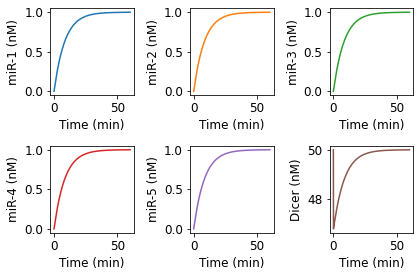

In [75]:
fig = plt.figure()
plt.rc('font', size=12)
plt.rcParams['svg.fonttype'] = 'none'

ax1 = plt.subplot(2,3,1)
ax1.plot(res3.t, mirna0, color = 'C0')
ax1.set_ylabel('miR-1 (nM)')
ax1.set_xlabel('Time (min)')

ax2 = plt.subplot(2,3,2, sharex=ax1, sharey=ax1)
ax2.plot(res3.t, mirna1, color = 'C1')
ax2.set_ylabel('miR-2 (nM)')
ax2.set_xlabel('Time (min)')

ax3 = plt.subplot(2,3,3, sharex=ax1, sharey=ax1)
ax3.plot(res3.t, mirna2, color = 'C2')
ax3.set_ylabel('miR-3 (nM)')
ax3.set_xlabel('Time (min)')

ax4 = plt.subplot(2,3,4, sharex=ax1, sharey=ax1)
ax4.plot(res3.t, mirna3, color = 'C3')
ax4.set_ylabel('miR-4 (nM)')
ax4.set_xlabel('Time (min)')

ax5 = plt.subplot(2,3,5, sharex=ax1, sharey=ax1)
ax5.plot(res3.t, mirna4, color = 'C4')
ax5.set_ylabel('miR-5 (nM)')
ax5.set_xlabel('Time (min)')

ax6 = plt.subplot(2,3,6)
ax6.plot(res3.t, dicer, color = 'C5')
ax6.set_ylabel('Dicer (nM)')
ax6.set_xlabel('Time (min)')

plt.tight_layout()

#fig.savefig(r'./figures/toy_model.svg', dpi = 600, bbox_inches = 'tight')

plt.show()